## <b><span style='color:#e61427'>|</span> Importing Libraries </b>

PyTorch Libraries for Building and Training Neural Networks


In [3]:
import torch  # Main PyTorch library for tensor operations
import torch.nn as nn  # Provides modules for defining neural network layers
import torch.nn.functional as F  # Contains functions for building neural networks (e.g., activation functions)
import torch.optim as optim  # Optimizers for model training (e.g., SGD, Adam)
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Reduce learning rate when a metric plateaus
from torch.utils.data import DataLoader, random_split  # Load and split datasets efficiently


Torchvision Libraries for Image Processing and Datasets

In [4]:
import torchvision  # Core library for image-based models and datasets
from torchvision import utils  # Utility functions for visualizing tensors and images
from torchvision.datasets import ImageFolder  # Load image datasets from folders
import torchvision.transforms as transforms  # Image transformations (e.g., resizing, normalizing)
from torchvision import datasets  # Built-in image datasets (e.g., CIFAR, MNIST)


General Libraries

In [5]:
import os  # Interact with the operating system (file and directory manipulation)
import shutil  # High-level file operations like copying, moving, and removing
import copy  # Create copies of objects to avoid unintended modifications
import itertools  # Tools for efficient looping and combinatorics
import pathlib  # For working with file and directory paths
import warnings  # Handle warnings and suppress unwanted ones
warnings.filterwarnings('ignore')  # Ignore warnings to keep the console output clean
import numpy as np  # Array manipulation and mathematical operations
import pandas as pd  # Data manipulation and analysis using dataframes
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import seaborn as sns  # Enhanced data visualization (built on top of Matplotlib)
sns.set(style='darkgrid')  # Set Seaborn's default theme for plots


Image Handling Library

In [6]:
from PIL import Image  # Open, manipulate, and save images

Progress Tracking


In [7]:
from tqdm.notebook import trange, tqdm  # Progress bars for loops and tracking long-running tasks

Evaluation and Metrics for Model Performance

In [8]:
from sklearn.metrics import confusion_matrix, classification_report  # Generate evaluation metrics like confusion matrix and classification report

Dataset Splitting

In [9]:
import splitfolders  # Split image dataset folders into train, validation, and test sets

Model Summary

In [10]:
from torchsummary import summary  # Display a summary of the neural network architecture

## <b>01<span style='color:#e61227'>|</span> Selection of Dataset and Exploratory Data Analysis </b>

#### <b><span style='color:#e61227'>|</span> Load dataset </b>

In [11]:
df = pd.read_csv('Dataset\metadata.csv')
print(df.head().to_markdown())

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


In [12]:
# Count occurrences of each format
format_counts = df['format'].value_counts()
print(format_counts)

format
JPEG    4496
TIFF      86
PNG       18
Name: count, dtype: int64


In [13]:
# Count occurrences of each mode
mode_counts = df['mode'].value_counts()
print(mode_counts)

mode
RGB     4461
L        132
RGBA       5
P          2
Name: count, dtype: int64


In [14]:
# Group by class and format to see the distribution
class_format_counts = df.groupby(['class', 'format']).size().reset_index(name='count')
print(class_format_counts)

    class format  count
0  normal   JPEG   2078
1  normal    PNG      9
2   tumor   JPEG   2418
3   tumor    PNG      9
4   tumor   TIFF     86


In [15]:
# Group by class and mode to see the distribution
class_mode_counts = df.groupby(['class', 'mode']).size().reset_index(name='count')
print(class_mode_counts)

    class  mode  count
0  normal     L     40
1  normal     P      2
2  normal   RGB   2040
3  normal  RGBA      5
4   tumor     L     92
5   tumor   RGB   2421


In [16]:

# Group by class, format, and shape to see the distribution of each combination
class_format_shape_counts = df.groupby(['class', 'format', 'shape']).size().reset_index(name='count')
print(class_format_shape_counts)

      class format            shape  count
0    normal   JPEG     (1024, 1024)      3
1    normal   JPEG  (1024, 1024, 3)      3
2    normal   JPEG   (1075, 890, 3)      2
3    normal   JPEG  (1446, 1375, 3)      1
4    normal   JPEG    (168, 300, 3)     52
..      ...    ...              ...    ...
483   tumor   JPEG    (938, 911, 3)     18
484   tumor   JPEG    (960, 781, 3)     15
485   tumor   JPEG    (993, 825, 3)      7
486   tumor    PNG       (300, 240)      9
487   tumor   TIFF    (256, 256, 3)     86

[488 rows x 4 columns]


In [17]:
os.listdir('Dataset\Brain Tumor Data Set')

['Brain Tumor', 'Healthy']

#### <b><span style='color:#e61227'>|</span> Preprocessing dataset </b>

In [18]:
# Define the source directory and destination directory
source_folder = 'Dataset\\Brain Tumor Data Set'  # Source folder
destination_folder = 'Dataset\\Data for processing'  # New folder name after copying

# Check if the source folder exists
if os.path.exists(source_folder):
    # Check if the destination folder exists
    if os.path.exists(destination_folder):
        # If it exists, remove it
        shutil.rmtree(destination_folder)
        print(f"Destination folder '{destination_folder}' already existed and was removed.")

    # Copy the entire directory structure to the new destination folder
    shutil.copytree(source_folder, destination_folder)
    print(f"Copied '{source_folder}' and renamed it as '{destination_folder}'")
else:
    print(f"The source folder '{source_folder}' does not exist.")

print("Processing complete.")



Copied 'Dataset\Brain Tumor Data Set' and renamed it as 'Dataset\Data for processing'
Processing complete.


In [19]:
import os
from PIL import Image

# Define the folder where files need to be processed
folder_to_process = 'Dataset/Data for processing'  # Folder containing files for processing

# Walk through the directory and check each file
for root, dirs, files in os.walk(folder_to_process):
    for filename in files:
        file_path = os.path.join(root, filename)
        
        try:
            # Open the image and check its mode
            with Image.open(file_path) as img:
                if img.mode != 'RGB':
                    # The file will be automatically closed when exiting the 'with' block
                    print(f"{filename} is not in RGB mode")
                    to_remove = True
                else:
                    to_remove = False
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            to_remove = True  # Mark file for deletion if it couldn't be opened as an image
        
        # Remove the file after it is closed
        if to_remove:
            try:
                os.remove(file_path)
                print(f"Removed {filename}")
            except Exception as e:
                print(f"Error removing {filename}: {e}")

print("Processing complete. Only RGB mode files are kept.")


Cancer (1).png is not in RGB mode
Removed Cancer (1).png
Cancer (1028).jpg is not in RGB mode
Removed Cancer (1028).jpg
Cancer (1209).jpg is not in RGB mode
Removed Cancer (1209).jpg
Cancer (1236).jpg is not in RGB mode
Removed Cancer (1236).jpg
Cancer (1258).jpg is not in RGB mode
Removed Cancer (1258).jpg
Cancer (1263).jpg is not in RGB mode
Removed Cancer (1263).jpg
Cancer (1266).jpg is not in RGB mode
Removed Cancer (1266).jpg
Cancer (1271).jpg is not in RGB mode
Removed Cancer (1271).jpg
Cancer (1282).jpg is not in RGB mode
Removed Cancer (1282).jpg
Cancer (1401).jpg is not in RGB mode
Removed Cancer (1401).jpg
Cancer (1404).jpg is not in RGB mode
Removed Cancer (1404).jpg
Cancer (1424).jpg is not in RGB mode
Removed Cancer (1424).jpg
Cancer (1448).jpg is not in RGB mode
Removed Cancer (1448).jpg
Cancer (1454).jpg is not in RGB mode
Removed Cancer (1454).jpg
Cancer (1458).jpg is not in RGB mode
Removed Cancer (1458).jpg
Cancer (1463).jpg is not in RGB mode
Removed Cancer (1463).jp

In [20]:
import os

# Define the root folder to count files in
folder_to_process = 'Dataset/Data for processing'

# Traverse the directory structure and count files in each subdirectory
for root, dirs, files in os.walk(folder_to_process):
    # Only print the count for directories (subdirectories)
    if len(files) > 0:
        print(f"Directory: {root}")
        print(f"Number of files: {len(files)}\n")


Directory: Dataset/Data for processing\Brain Tumor
Number of files: 2421

Directory: Dataset/Data for processing\Healthy
Number of files: 2040



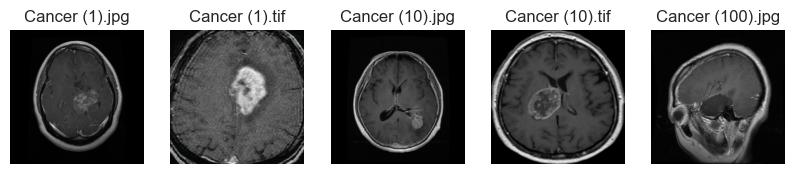

In [21]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the folder path where the images are stored
folder_path = 'Dataset/Data for processing/Brain Tumor'

# Get the list of image files from the folder
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Set the number of images you want to display
num_images_to_show = 5 # Change this to the number of images you want to visualize

# Loop through the images and visualize them
plt.figure(figsize=(10, 10))  # Set the figure size
for i, image_name in enumerate(image_files[:num_images_to_show]):
    img_path = os.path.join(folder_path, image_name)
    
    try:
        # Open the image
        img = Image.open(img_path)
        
        # Display the image in the plot
        plt.subplot(1, num_images_to_show, i + 1)
        plt.imshow(img)
        plt.title(image_name)
        plt.axis('off')  # Turn off the axes for clarity
    except Exception as e:
        print(f"Error loading image {image_name}: {e}")

plt.show()


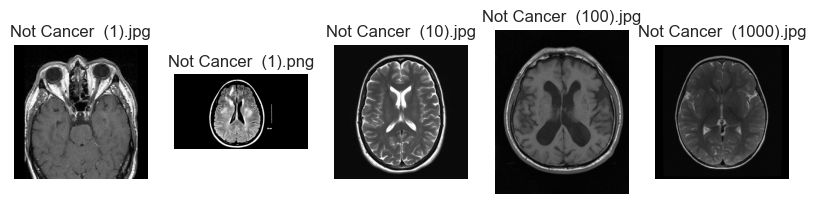

In [22]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the folder path where the images are stored
folder_path = 'Dataset/Data for processing/Healthy'

# Get the list of image files from the folder
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Set the number of images you want to display
num_images_to_show = 5  # Change this to the number of images you want to visualize

# Loop through the images and visualize them
plt.figure(figsize=(10, 10))  # Set the figure size
for i, image_name in enumerate(image_files[:num_images_to_show]):
    img_path = os.path.join(folder_path, image_name)
    
    try:
        # Open the image
        img = Image.open(img_path)
        
        # Display the image in the plot
        plt.subplot(1, num_images_to_show, i + 1)
        plt.imshow(img)
        plt.title(image_name)
        plt.axis('off')  # Turn off the axes for clarity
    except Exception as e:
        print(f"Error loading image {image_name}: {e}")

plt.show()


In [23]:
# Paths to your folders
healthy_folder = 'Dataset/Data for processing/Healthy'
tumor_folder = 'Dataset/Data for processing/Brain Tumor'

# List all image files in the folders
healthy_images = [os.path.join(healthy_folder, img) for img in os.listdir(healthy_folder) if img.endswith(('jpg', 'png', 'jpeg'))]
tumor_images = [os.path.join(tumor_folder, img) for img in os.listdir(tumor_folder) if img.endswith(('jpg', 'png', 'jpeg'))]

# Combine both sets of images
all_images = healthy_images + tumor_images


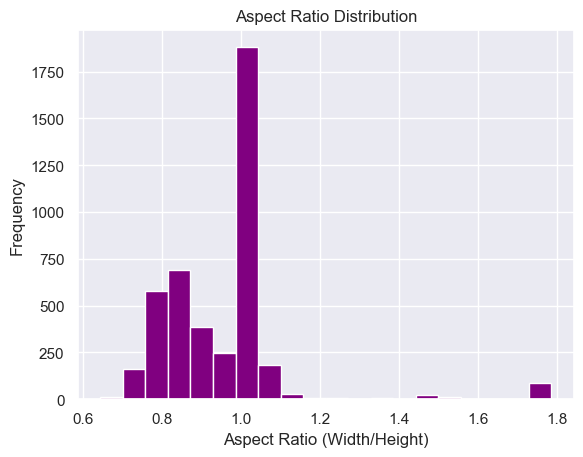

In [24]:
# Aspect Ratio Analysis
# Calculate the aspect ratio of each image and plot the distribution.
aspect_ratios = []

for img_path in all_images:
    img = Image.open(img_path)
    width, height = img.size
    aspect_ratios.append(width / height)

# Plot the aspect ratio distribution
plt.hist(aspect_ratios, bins=20, color='purple')
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')
plt.show()


In [25]:
# Check for Corrupt or Blank Images
# You can check for blank images (images with uniform pixel values) and corrupt images that cannot be opened.

corrupt_images = []
blank_images = []

for img_path in all_images:
    try:
        img = Image.open(img_path)
        img_array = np.array(img)

        # Check if image is blank (all pixels have the same value)
        if np.all(img_array == img_array[0, 0]):
            blank_images.append(img_path)

    except Exception as e:
        # If there's an error opening the image, consider it corrupt
        corrupt_images.append(img_path)

print(f"Number of corrupt images: {len(corrupt_images)}")
print(f"Number of blank images: {len(blank_images)}")


Number of corrupt images: 0
Number of blank images: 0


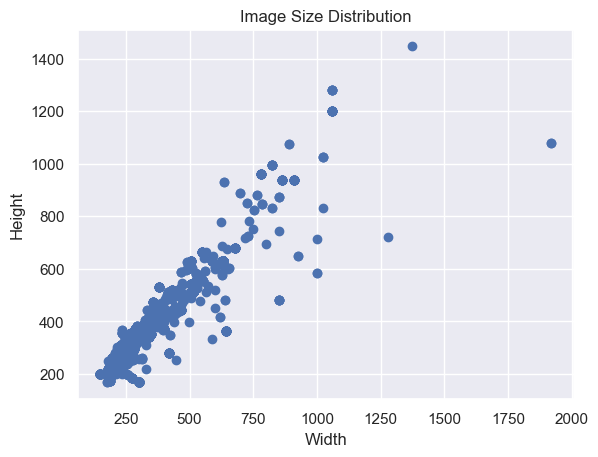

In [27]:
# Image Size Distribution
# Analyze the dimensions of each image and plot the distribution of widths and heights.

image_sizes = []

for img_path in all_images:
    img = Image.open(img_path)
    width, height = img.size
    image_sizes.append((width, height))

# Separate the widths and heights for plotting
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]

# Plot width and height distributions
plt.scatter(widths, heights)
plt.title('Image Size Distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


#### <b><span style='color:#e61227'>|</span> Split dataset </b>

In [28]:
# Dataset Path
data_dir = 'Dataset/Data for processing'
data_dir = pathlib.Path(data_dir)

# Splitting dataset to train_set, val_set and test_set
splitfolders.ratio(data_dir, output='Dataset/Working data', seed=20, ratio=(0.7, 0.3))


# New dataset path
data_dir = 'Dataset/Working data'
data_dir = pathlib.Path(data_dir)

Copying files: 4461 files [00:03, 1473.24 files/s]


In [29]:
# Define the root folder to count files in
folder_to_process = 'Dataset/Working data'

# Traverse the directory structure and count files in each subdirectory
for root, dirs, files in os.walk(folder_to_process):
    # Only print the count for directories (subdirectories)
    if len(files) > 0:
        print(f"Directory: {root}")
        print(f"Number of files: {len(files)}\n")


Directory: Dataset/Working data\train\Brain Tumor
Number of files: 1694

Directory: Dataset/Working data\train\Healthy
Number of files: 1428

Directory: Dataset/Working data\val\Brain Tumor
Number of files: 727

Directory: Dataset/Working data\val\Healthy
Number of files: 612



#### <b><span style='color:#e61227'>|</span> Image Augmentation </b>

In [31]:
# define transformation
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

Here's a breakdown of why each transformation is used:

transforms.Resize((256, 256)):
    Purpose: Ensures that all input images are resized to a uniform size of 256x256 pixels, which is essential because neural networks require fixed-size inputs.

transforms.RandomHorizontalFlip(p=0.5):
    Purpose: Randomly flips the image horizontally with a probability of 50%. This is a data augmentation technique to help the model generalize better by learning from multiple variations of the same image (e.g., flipping a cat's picture would not change the fact it's still a cat).

transforms.RandomVerticalFlip(p=0.5):
    Purpose: Similar to the horizontal flip, this randomly flips the image vertically with a 50% probability. This adds more variety to the training data, especially useful in cases where vertical symmetry doesn't change the label (e.g., in medical or satellite images).

transforms.RandomRotation(30):
    Purpose: Randomly rotates the image by up to 30 degrees. This further helps with data augmentation, making the model more robust to variations in orientation.

transforms.ToTensor():
    Purpose: Converts the image from a PIL (Python Imaging Library) format to a PyTorch tensor, which is the format required by PyTorch models. It also scales the pixel values from the range [0, 255] to [0, 1].

transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    Purpose: Normalizes the image using the mean and standard deviation of the ImageNet dataset. Pretrained models, like those trained on ImageNet, expect inputs to have these specific mean and standard deviation values. This step standardizes the input data, making it easier for the network to learn effectively.

In [32]:
# Define an object of the custom dataset for the train and validation.
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform) 
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

#### <b><span style='color:#e61227'>|</span> Data Analysis and Visualisation </b>

##### <b><I> Dataset Dimensions and Shape </I></b>

In [33]:
# Checking dimensions of a random image
img, label = train_set[100]  # Getting the first image from the dataset
print(f"Image shape: {img.shape}")


Image shape: torch.Size([3, 256, 256])


In [34]:
# Checking dimensions of a random image
img, label = val_set[100]  # Getting the first image from the dataset
print(f"Image shape: {img.shape}")


Image shape: torch.Size([3, 256, 256])


##### <b><I> Class Distribution (Frequency of Labels) </I></b> 

Brain Tumor: 1694 images
Healthy: 1428 images


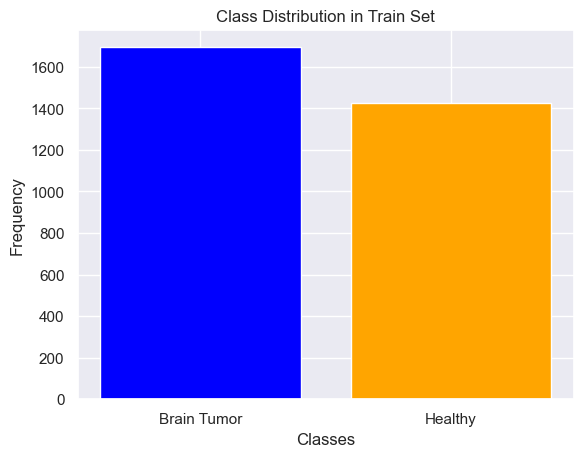

In [35]:
'''  It’s crucial to check if the dataset is balanced, especially for classification tasks.'''

from collections import Counter

CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
}
# Extract all labels from the train_set
labels = [label for _, label in train_set]
label_count = Counter(labels)

# Display the count of each label
for label, count in label_count.items():
    print(f"{CLA_label[label]}: {count} images")
    
# Plot the class distribution
plt.bar(CLA_label.values(), label_count.values(), color=['blue', 'orange'])
plt.title('Class Distribution in Train Set')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

Brain Tumor: 727 images
Healthy: 612 images


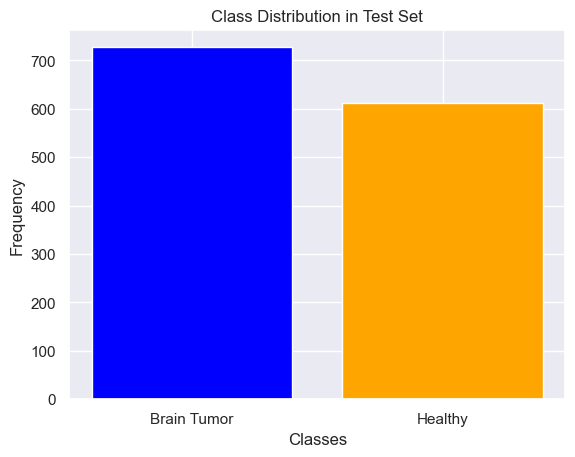

In [36]:
from collections import Counter

CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
}
# Extract all labels from the train_set
labels = [label for _, label in val_set]
label_count = Counter(labels)

# Display the count of each label
for label, count in label_count.items():
    print(f"{CLA_label[label]}: {count} images")
    
# Plot the class distribution
plt.bar(CLA_label.values(), label_count.values(), color=['blue', 'orange'])
plt.title('Class Distribution in Test Set')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

##### <b><I> Aspect Ratio Analysis </I></b> 

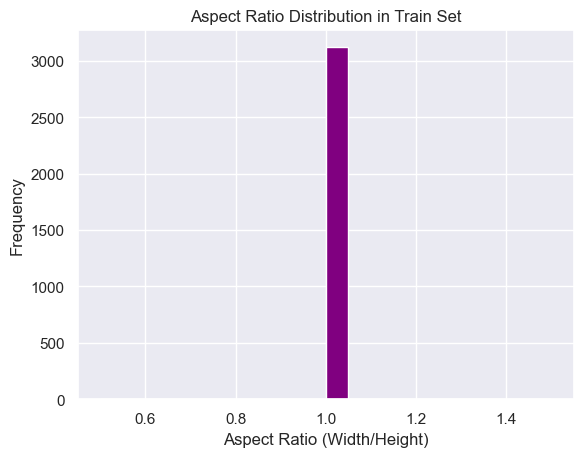

In [37]:
# Check the aspect ratios of the images to determine if any resizing needs to be handled differently during preprocessing.
aspect_ratios = [img.shape[1] / img.shape[2] for img, _ in train_set]

# Plot the aspect ratio distribution
plt.hist(aspect_ratios, bins=20, color='purple')
plt.title('Aspect Ratio Distribution in Train Set')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')
plt.show()


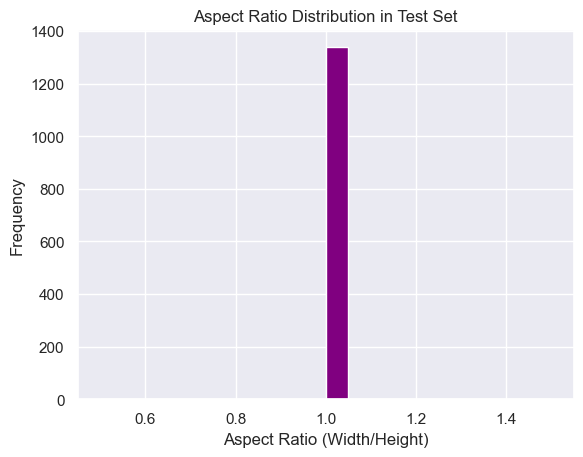

In [38]:
# Check the aspect ratios of the images to determine if any resizing needs to be handled differently during preprocessing.
aspect_ratios = [img.shape[1] / img.shape[2] for img, _ in val_set]

# Plot the aspect ratio distribution
plt.hist(aspect_ratios, bins=20, color='purple')
plt.title('Aspect Ratio Distribution in Test Set')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')
plt.show()


##### <b><I> Corrupt or Blank Images </I></b> 

In [39]:
# Find any corrupt/blank images
corrupt_images = []
for i in range(len(train_set)):
    img, label = train_set[i]
    if img.mean() == 0 or img.std() == 0:  # Blank or near-blank image
        corrupt_images.append(i)

print(f"Number of potentially corrupt images: {len(corrupt_images)}")


Number of potentially corrupt images: 0


In [40]:
# Find any corrupt/blank images
corrupt_images = []
for i in range(len(val_set)):
    img, label = val_set[i]
    if img.mean() == 0 or img.std() == 0:  # Blank or near-blank image
        corrupt_images.append(i)

print(f"Number of potentially corrupt images: {len(corrupt_images)}")


Number of potentially corrupt images: 0


##### <b><I> Image Size Distribution </I></b> 

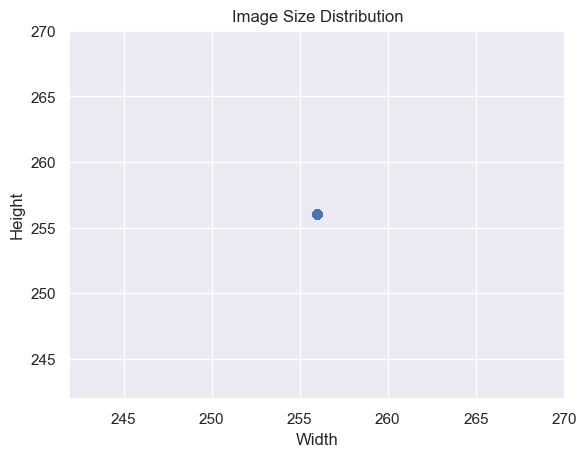

In [41]:
image_sizes = [img.shape[1:] for img, _ in train_set]

# Plot distribution of image sizes
widths = [size[1] for size in image_sizes]
heights = [size[0] for size in image_sizes]

plt.scatter(widths, heights)
plt.title('Image Size Distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


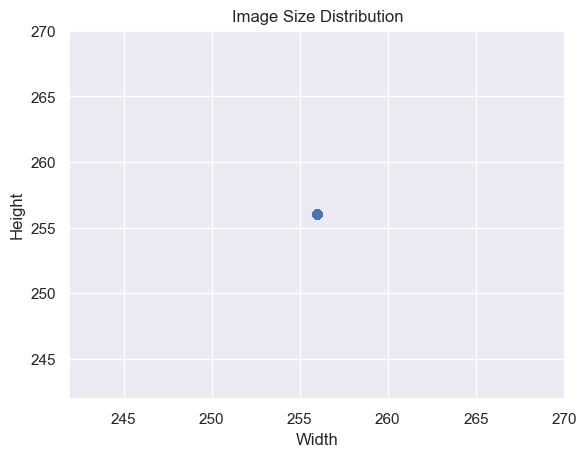

In [42]:
image_sizes = [img.shape[1:] for img, _ in val_set]

# Plot distribution of image sizes
widths = [size[1] for size in image_sizes]
heights = [size[0] for size in image_sizes]

plt.scatter(widths, heights)
plt.title('Image Size Distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

##### <b><I> Image Augmentation Visualization </I></b> 

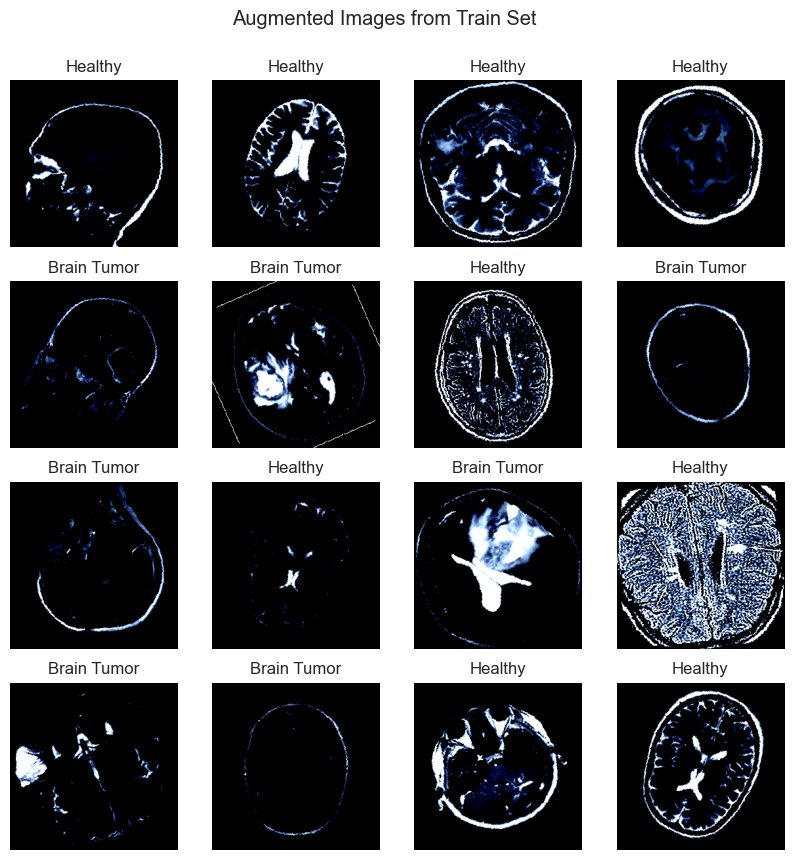

In [43]:
import torchvision.transforms as transforms

# Example of a simple augmentation
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
])

# Visualize some augmented images
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    img = augmentation(img)  # Apply augmentations
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Augmented Images from Train Set', y=0.95)
plt.show()


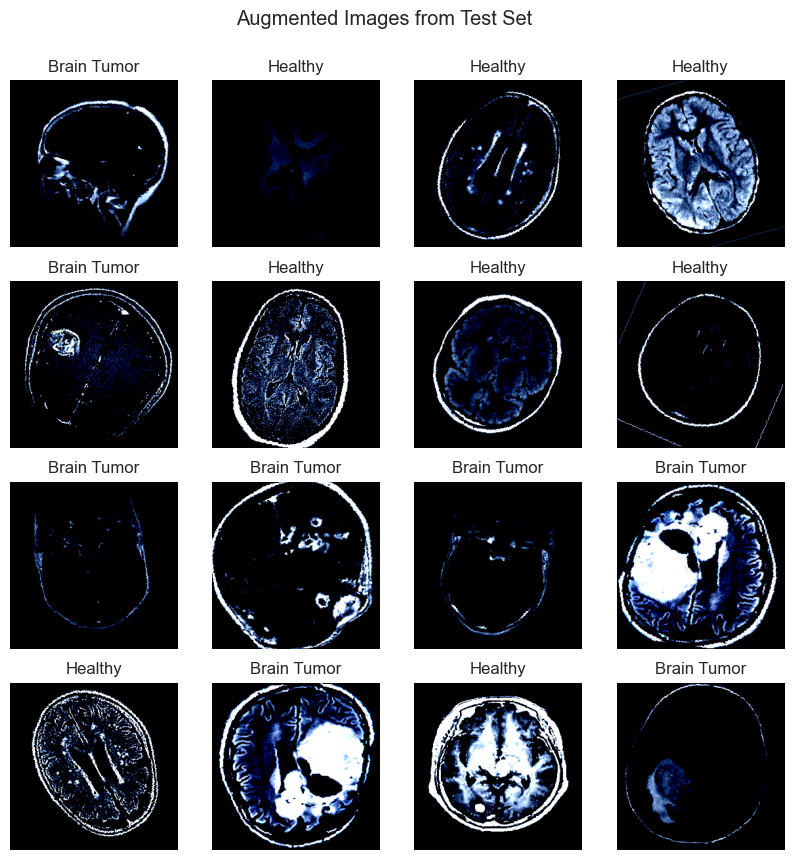

In [44]:
import torchvision.transforms as transforms

# Example of a simple augmentation
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
])

# Visualize some augmented images
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(val_set), size=(1,)).item()
    img, label = val_set[sample_idx]
    img = augmentation(img)  # Apply augmentations
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Augmented Images from Test Set', y=0.95)
plt.show()

## <b>02<span style='color:#e61227'>|</span> Model Development and Evaluation </b>

#### <b><span style='color:#e61227'>|</span> Creating Dataloaders </b>

In [46]:
batch_size = 32  # Set the batch size for loading data. This defines how many samples will be processed at once.

# Create a DataLoader for the training dataset
train_loader = torch.utils.data.DataLoader(
    train_set,                # The dataset to load (training data)
    batch_size=batch_size,    # Number of samples per batch
    shuffle=True,             # Shuffle the dataset at every epoch to improve generalization
    num_workers=2             # Number of subprocesses to use for data loading; 2 is a reasonable choice for most systems
)

# Create a DataLoader for the validation dataset
val_loader = torch.utils.data.DataLoader(
    val_set,                  # The dataset to load (validation data)
    batch_size=batch_size,    # Number of samples per batch
    shuffle=True,             # Shuffle the dataset at every epoch; this is typically done for training but can also be applied to validation
    num_workers=2             # Number of subprocesses to use for data loading
)


In [47]:
'''
The DataLoader object contains multiple batches of data.

Each batch contains two components:
    X: A tensor representing the input data (e.g., images).
    y: A tensor representing the labels corresponding to the input data.

The shapes are printed for the first batch of both the training data and the validation data:
    Shape of X: Could be something like (32, 3, 256, 256) for 64 images of size 256x256 with 3 channels (RGB).
    Shape of y: Typically (64,) for the corresponding labels of those 64 images.

'''


# Print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    # Iterate over a dictionary containing the DataLoaders for training and validation
    for X, y in value:
        # Get the first batch of data from the DataLoader
        print(f"{key}:")  # Print the key (either 'Training data' or 'Validation data')
        print(f"Shape of X : {X.shape}")  # Print the shape of the input data (X)
        print(f"Shape of y: {y.shape} {y.dtype}\n")  # Print the shape and data type of the labels (y)
        break  # Break after printing the shape for the first batch


Training data:
Shape of X : torch.Size([32, 3, 256, 256])
Shape of y: torch.Size([32]) torch.int64

Validation data:
Shape of X : torch.Size([32, 3, 256, 256])
Shape of y: torch.Size([32]) torch.int64



#### <b><span style='color:#e61227'>|</span> Define Brain Tumor Classifier </b>

In [48]:
'''This function can be useful in determining the output size of a convolutional layer in a neural network,
given the input dimensions and the convolutional layer's parameters.

The function findConv2dOutShape is designed to calculate the output height and width of a 2D convolutional layer followed by an optional pooling layer, given the input dimensions (height and width) and the parameters of the convolution.

Parameters:
hin: Height of the input.
win: Width of the input.
conv: A 2D convolutional layer (e.g., torch.nn.Conv2d). 
The convolution layer contains important parameters like kernel size, stride, padding, and dilation.
    Key Variables from the conv Layer:
        kernel_size: The size of the convolutional filter (e.g., 3x3, 5x5).
        stride: The step size of the filter as it moves across the input.
        padding: The number of pixels added to the border of the input before convolution.
        dilation: Controls the spacing between the kernel points.
pool: The pooling layer size. 
By default, this is set to 2 for a typical pooling operation (like MaxPool2d), but it can be set to None if there is no pooling layer.

Input Image: The original image with dimensions H_in x W_in.
Output Feature Map: After convolution, the feature map dimensions are H_out x W_out
'''

def findConv2dOutShape(hin, win, conv, pool=2):
    # Define a function to compute the output height and width of a 2D convolutional layer
    # hin: Input height
    # win: Input width
    # conv: Convolutional layer object (e.g., nn.Conv2d)
    # pool: Pooling size (default is 2, which is typical for max pooling)

    # Get convolutional layer parameters
    kernel_size = conv.kernel_size  # Size of the convolutional filter (e.g., (3, 3))
    stride = conv.stride            # Stride of the convolution (e.g., (1, 1))
    padding = conv.padding          # Padding applied to the input (e.g., (1, 1))
    dilation = conv.dilation        # Dilation of the convolution (spacing between kernel elements)

    # Calculate the output height after convolution
    hout = np.floor((hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
    # Formula breakdown:
    # hin: Input height
    # + 2 * padding[0]: Add padding on top and bottom
    # - dilation[0] * (kernel_size[0] - 1): Account for dilation
    # - 1: Adjust for the filter's effect
    # / stride[0]: Divide by the stride to get the number of strides taken
    # + 1: Include the starting position in the count

    # Calculate the output width after convolution
    wout = np.floor((win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)
    # Formula breakdown: Similar to height calculation but for width

    # If a pooling layer follows, adjust the output dimensions
    if pool:
        hout /= pool  # Divide output height by pooling size
        wout /= pool  # Divide output width by pooling size

    # Return the computed output dimensions as integers
    return int(hout), int(wout)


In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define Architecture For CNN_BT Model
class CNN_BT(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        # Call the constructor of the parent class nn.Module
        super(CNN_BT, self).__init__()
        
        # Extract parameters from the input dictionary
        Cin, Hin, Win = params["shape_in"]  # Input channels, height, and width of the input image
        init_f = params["initial_filters"]   # Initial number of filters for the first convolution layer
        num_fc1 = params["num_fc1"]          # Number of units in the first fully connected layer
        num_classes = params["num_classes"]   # Number of output classes for classification
        self.dropout_rate = params["dropout_rate"]  # Dropout rate for regularization
        
        # Convolution Layers
        # Define the first convolutional layer with 3x3 kernel
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        # Calculate the output height and width after conv1
        h, w = findConv2dOutShape(Hin, Win, self.conv1)
        
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(init_f, 2 * init_f, kernel_size=3)
        # Calculate the output height and width after conv2
        h, w = findConv2dOutShape(h, w, self.conv2)
        
        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(2 * init_f, 4 * init_f, kernel_size=3)
        # Calculate the output height and width after conv3
        h, w = findConv2dOutShape(h, w, self.conv3)
        
        # Define the fourth convolutional layer
        self.conv4 = nn.Conv2d(4 * init_f, 8 * init_f, kernel_size=3)
        # Calculate the output height and width after conv4
        h, w = findConv2dOutShape(h, w, self.conv4)
        
        # Compute the size of the flattened layer after convolutions
        self.num_flatten = h * w * 8 * init_f  # This will be the input size for the first fully connected layer
        # Define the first fully connected layer
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        # Define the second fully connected layer (output layer)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, X):
        # Forward pass through the network
        # Apply ReLU activation and max pooling after each convolution
        X = F.relu(self.conv1(X))  # Apply conv1 and ReLU activation
        X = F.max_pool2d(X, 2, 2)  # Apply max pooling with a 2x2 window and a stride of 2
        X = F.relu(self.conv2(X))  # Apply conv2 and ReLU activation
        X = F.max_pool2d(X, 2, 2)  # Max pooling
        X = F.relu(self.conv3(X))  # Apply conv3 and ReLU activation
        X = F.max_pool2d(X, 2, 2)  # Max pooling
        X = F.relu(self.conv4(X))  # Apply conv4 and ReLU activation
        X = F.max_pool2d(X, 2, 2)  # Max pooling
        
        # Flatten the output for the fully connected layers
        X = X.view(-1, self.num_flatten)  # Reshape to (batch_size, num_flatten)
        X = F.relu(self.fc1(X))  # Apply the first fully connected layer and ReLU activation
        X = F.dropout(X, self.dropout_rate)  # Apply dropout for regularization
        X = self.fc2(X)  # Apply the second fully connected layer (output layer)
        
        # Return the output probabilities after applying softmax
        return F.log_softmax(X, dim=1)  # Logarithm of softmax for numerical stability


In [50]:
# Define a dictionary containing parameters for the CNN model
params = {
    "shape_in": (3, 256, 256),  # Input shape: 3 channels (RGB), height = 256, width = 256
    "initial_filters": 8,        # Number of filters in the first convolutional layer
    "num_fc1": 100,              # Number of neurons in the first fully connected layer
    "dropout_rate": 0.25,        # Dropout rate for regularization to prevent overfitting
    "num_classes": 2              # Number of output classes for classification (e.g., healthy and tumor)
}

# Create an instance of the CNN_TUMOR class with the specified parameters
cnn_model = CNN_BT(params)

# Determine the computation hardware to use (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# This line checks if a CUDA-capable GPU is available; if so, it sets the device to 'cuda'.
# If no GPU is available, it defaults to 'cpu'.

# Move the CNN model to the specified device (GPU or CPU)
model = cnn_model.to(device)
# This line transfers the model's parameters and buffers to the specified device, allowing it to utilize the GPU for faster computation if available.


In [51]:
'''
Layer Type: The type of each layer (e.g., convolutional, fully connected).
Output Shape: The shape of the output tensor after each layer.
Param #: The number of trainable parameters in each layer.
Total Parameters: The total number of parameters in the entire model.
Trainable Parameters: The subset of parameters that will be updated during training.
'''

# Model Summary for CNN Model

summary(cnn_model, input_size=(3, 256, 256),device=device.type)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0

#### <b><span style='color:#e61227'>|</span> Loss Function Definition  </b>

NLLLoss is particularly useful when dealing with classification problems where you want to measure how well the predicted probabilities (in log form) match the true class labels.

It is used when you are modeling probabilities of multiple classes and you apply the log_softmax function to your model's outputs before passing them to this loss function.

In [52]:
'''
NLLLoss stands for Negative Log Likelihood Loss. 
It is commonly used for multi-class classification problems, 
especially in combination with the softmax activation function in the output layer.
NLLLoss expects the input to be log probabilities (which is why it is typically used after a log_softmax output), 
and it computes the loss between the predicted log probabilities and the true class labels.

reduction="sum":
The reduction parameter specifies how the computed loss values are aggregated.
In this case, "sum" means that the losses for all samples in the batch will be summed together. 
This results in a single loss value representing the total loss for the entire batch.
Other possible values for reduction include:
    "mean": Returns the average loss across the batch.
    "none": Returns the loss for each sample without any aggregation.

'''

loss_func = nn.NLLLoss(reduction="sum")

#### <b><span style='color:#e61227'>|</span> Optimiser Definition </b>

The code initializes the Adam optimizer for training the CNN model, specifying a starting learning rate.

It also sets up a learning rate scheduler that will reduce the learning rate when the monitored metric (e.g., validation loss) does not improve for a specified number of epochs. 
This helps the model converge more effectively and avoid getting stuck in local minima.

In [53]:
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
# Create an Adam optimizer for the CNN model parameters with a learning rate of 0.0003 (3e-4)

lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)
# Initialize a learning rate scheduler that reduces the learning rate when a monitored quantity has stopped improving


#### <b><span style='color:#e61227'>|</span> Loss and Metric </b>

In [54]:
# Function to get the learning rate
def get_lr(opt):
    # Iterate through the parameter groups in the optimizer
    for param_group in opt.param_groups:
        # Return the learning rate from the first parameter group
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target)  # Calculate the loss using the loss function
    pred = output.argmax(dim=1, keepdim=True)  # Get the predicted class by finding the index of the maximum output
    metric_b = pred.eq(target.view_as(pred)).sum().item()  # Calculate the number of correct predictions (performance metric)
    
    # If an optimizer is provided, perform backpropagation
    if opt is not None:
        opt.zero_grad()  # Zero the gradients for the optimizer
        loss.backward()  # Backpropagate the loss to compute gradients
        opt.step()       # Update the model parameters based on the gradients

    return loss.item(), metric_b  # Return the loss as a Python float and the performance metric

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model, loss_func, dataset_dl, opt=None):
    
    run_loss = 0.0  # Initialize the running loss accumulator
    t_metric = 0.0  # Initialize the total metric accumulator
    len_data = len(dataset_dl.dataset)  # Get the total number of samples in the dataset

    # Internal loop over the dataset
    for xb, yb in dataset_dl:
        # Move the input batch and target labels to the appropriate device (GPU/CPU)
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)  # Get the model's output for the input batch
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)  # Calculate loss and metric for this batch
        run_loss += loss_b  # Update the running loss with the current batch loss

        if metric_b is not None:  # If there is a valid metric calculated
            t_metric += metric_b  # Update the total metric

    # Calculate the average loss over the entire dataset
    loss = run_loss / float(len_data)  # Average loss value
    metric = t_metric / float(len_data)  # Average metric value
    
    return loss, metric  # Return the average loss and average metric


#### <b><span style='color:#e61227'>|</span> Training Function</b>

In [55]:
def Train_Val(model, params, verbose=False):
    # Define a function to train and validate the model
    # model: the neural network model to train
    # params: a dictionary containing training parameters
    # verbose: if True, print detailed training information

    # Get the parameters from the input dictionary
    epochs = params["epochs"]               # Total number of training epochs
    loss_func = params["f_loss"]            # Loss function to be used for training
    opt = params["optimiser"]               # Optimizer for updating model weights
    train_dl = params["train"]              # DataLoader for the training dataset
    val_dl = params["val"]                  # DataLoader for the validation dataset
    lr_scheduler = params["lr_change"]      # Learning rate scheduler
    weight_path = params["weight_path"]     # File path to save the model weights

    # Initialize a history of loss values for training and validation
    loss_history = {"train": [], "val": []} 
    # Initialize a history of performance metric values for training and validation
    metric_history = {"train": [], "val": []} 
    # Make a deep copy of the model weights to keep track of the best performing model
    best_model_wts = copy.deepcopy(model.state_dict()) 
    # Initialize the best loss to a very large value
    best_loss = float('inf') 

    # Train the model for a specified number of epochs, with progress displayed by tqdm
    for epoch in tqdm(range(epochs)):
        
        # Get the current learning rate
        current_lr = get_lr(opt)  # Retrieve the learning rate from the optimizer
        if verbose:
            # Print the current epoch number and learning rate if verbose is enabled
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))

        # Training Phase
        model.train()  # Set the model to training mode
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)  # Compute loss and metric for training dataset

        # Collect training losses and metrics
        loss_history["train"].append(train_loss)  # Append training loss to history
        metric_history["train"].append(train_metric)  # Append training metric to history

        # Evaluation Phase
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculations to save memory during evaluation
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)  # Compute loss and metric for validation dataset
        
        # Store the best model weights if validation loss improves
        if val_loss < best_loss:
            best_loss = val_loss  # Update the best loss
            best_model_wts = copy.deepcopy(model.state_dict())  # Store the current model weights
            
            # Save the best model weights to a file
            torch.save(model.state_dict(), weight_path)  # Save the model's state dictionary to the specified path
            if verbose:
                print("Copied best model weights!")  # Print confirmation message

        # Collect validation losses and metrics
        loss_history["val"].append(val_loss)  # Append validation loss to history
        metric_history["val"].append(val_metric)  # Append validation metric to history
        
        # Update the learning rate based on validation loss
        lr_scheduler.step(val_loss)  # Adjust the learning rate based on the scheduler
        if current_lr != get_lr(opt):  # Check if the learning rate has changed
            if verbose:
                print("Loading best model weights!")  # Print message if loading best weights
            model.load_state_dict(best_model_wts)  # Load the best model weights

        if verbose:
            # Print training and validation loss and accuracy if verbose is enabled
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100 * val_metric:.2f}")
            print("-" * 10)  # Print a separator line

    # Load the best model weights after training is complete
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history  # Return the trained model and the loss/metric histories


#### <b><span style='color:#e61227'>|</span> Model Training</b>

In [56]:
# Define various parameters used for training and evaluation of a cnn_model
params_train = {
    "train": train_loader,  # DataLoader for the training dataset
    "val": val_loader,      # DataLoader for the validation dataset
    "epochs": 60,           # Number of training epochs
    "optimiser": optim.Adam(cnn_model.parameters(), lr=3e-4),  # Adam optimizer with a learning rate of 0.0003
    "lr_change": ReduceLROnPlateau(opt,
                                    mode='min',          # Monitor the validation loss for minimization
                                    factor=0.5,         # Reduce the learning rate by half when triggered
                                    patience=20,        # Wait for 20 epochs with no improvement before reducing the learning rate
                                    verbose=0),         # No output messages when learning rate is adjusted
    "f_loss": nn.NLLLoss(reduction="sum"),  # Negative Log Likelihood Loss with summation of losses
    "weight_path": "weights.pt",  # File path to save the model weights
}

# Train and validate the model
cnn_model, loss_hist, metric_hist = Train_Val(cnn_model, params_train)


  0%|          | 0/60 [00:00<?, ?it/s]

#### <b><span style='color:#e61227'>|</span> Model Evaluation</b>

Confusion_Matrix

In [57]:
# Define function for obtaining true and predicted labels from the validation set
def Ture_and_Pred(val_loader, model):
    i = 0  # Initialize a counter (not used further)
    y_true = []  # List to store true labels
    y_pred = []  # List to store predicted labels

    # Loop through the validation DataLoader
    for images, labels in val_loader:
        images = images.to(device)  # Move images to the appropriate device (GPU/CPU)
        labels = labels.numpy()  # Convert labels to a NumPy array for easier manipulation
        outputs = model(images)  # Get model predictions for the input images
        _, pred = torch.max(outputs.data, 1)  # Get the index of the maximum score (predicted class)
        pred = pred.detach().cpu().numpy()  # Move predictions to CPU and convert to NumPy array
        
        # Append the true labels and predicted labels to their respective lists
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred  # Return the lists of true and predicted labels


# Check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)  # Get true and predicted labels using the function

# Print classification report to evaluate model performance
print(classification_report(y_true, y_pred), '\n\n')

# Calculate confusion matrix for further error analysis
cm = confusion_matrix(y_true, y_pred)  # Create the confusion matrix from true and predicted labels


              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       727
         1.0       0.95      0.98      0.97       612

    accuracy                           0.97      1339
   macro avg       0.97      0.97      0.97      1339
weighted avg       0.97      0.97      0.97      1339
 




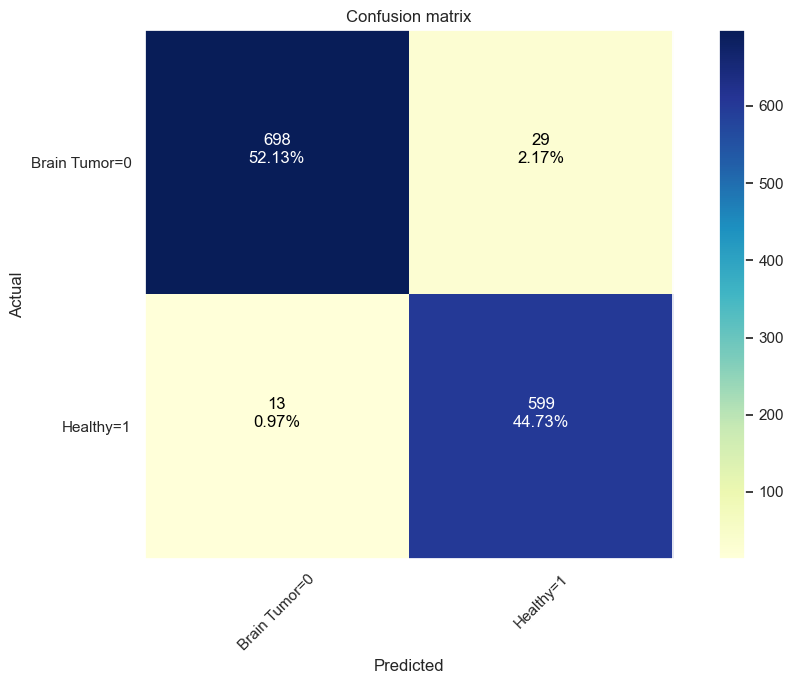

In [58]:
# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    # Define a function to plot a confusion matrix
    # cm: confusion matrix
    # CLA_label: dictionary mapping class indices to class names
    # title: title of the plot
    # cmap: color map for the plot

    plt.figure(figsize=(10, 7))  # Create a new figure with a specified size (10x7 inches)
    plt.grid(False)  # Disable the grid for better visual clarity
    plt.imshow(cm, interpolation='nearest', cmap=cmap)  # Display the confusion matrix as an image with the specified colormap
    plt.title(title)  # Set the title of the plot
    plt.colorbar()  # Add a color bar to indicate the scale of values

    tick_marks = np.arange(len(CLA_label))  # Create an array of tick marks for the class labels
    # Set x-axis ticks and labels with class names, rotated 45 degrees for better readability
    plt.xticks(tick_marks, [f"{value}={key}" for key, value in CLA_label.items()], rotation=45)
    # Set y-axis ticks and labels with class names
    plt.yticks(tick_marks, [f"{value}={key}" for key, value in CLA_label.items()])

    thresh = cm.max() / 2.  # Determine the threshold for text color based on the maximum value in the confusion matrix
    # Iterate over each cell in the confusion matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Place text in each cell showing the number and percentage of predictions
        plt.text(j, i, f"{cm[i, j]}\n{cm[i, j] / np.sum(cm) * 100:.2f}%", 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")  # Choose text color based on the threshold

    plt.ylabel('Actual')  # Label for the y-axis
    plt.xlabel('Predicted')  # Label for the x-axis
    plt.tight_layout()  # Adjust the layout to fit everything nicely
    plt.show()  # Display the plot

# Call the function to show the confusion matrix
show_confusion_matrix(cm, CLA_label)


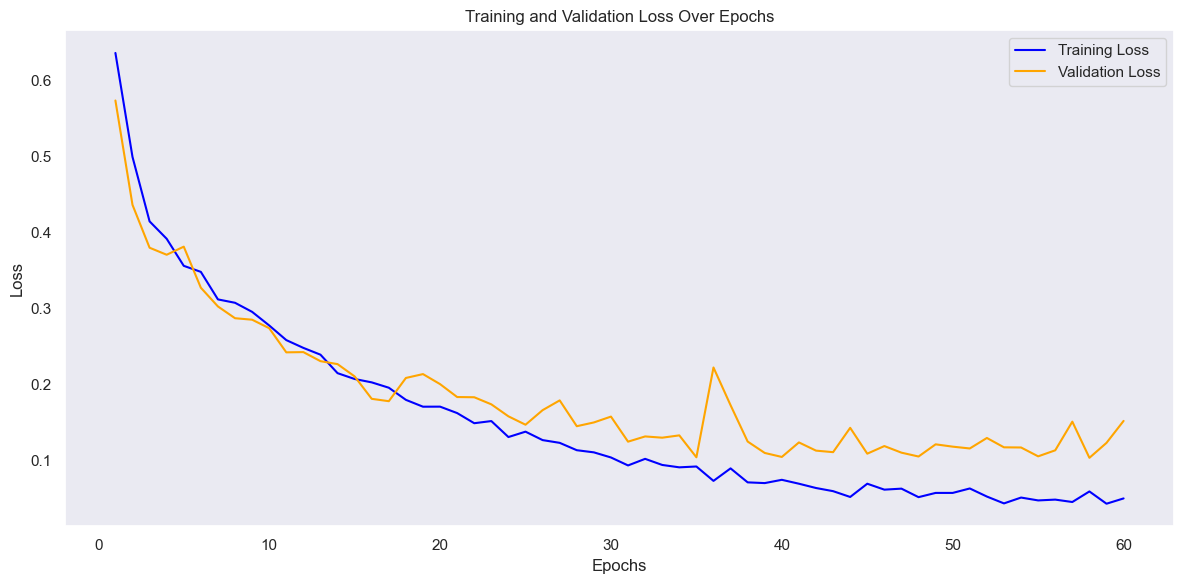

In [60]:
import matplotlib.pyplot as plt

# Extract the number of epochs from the training parameters
epochs = params_train["epochs"]

# Create a new figure for the plots
plt.figure(figsize=(12, 6))

# Plot training loss
plt.plot(range(1, epochs + 1), loss_hist["train"], label='Training Loss', color='blue')

# Plot validation loss
plt.plot(range(1, epochs + 1), loss_hist["val"], label='Validation Loss', color='orange')

# Add titles and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to distinguish between training and validation loss
plt.legend()

# Optionally add gridlines for better readability
plt.grid()

# Show the plot
plt.tight_layout()  # Adjust layout to make it look nice
plt.show()


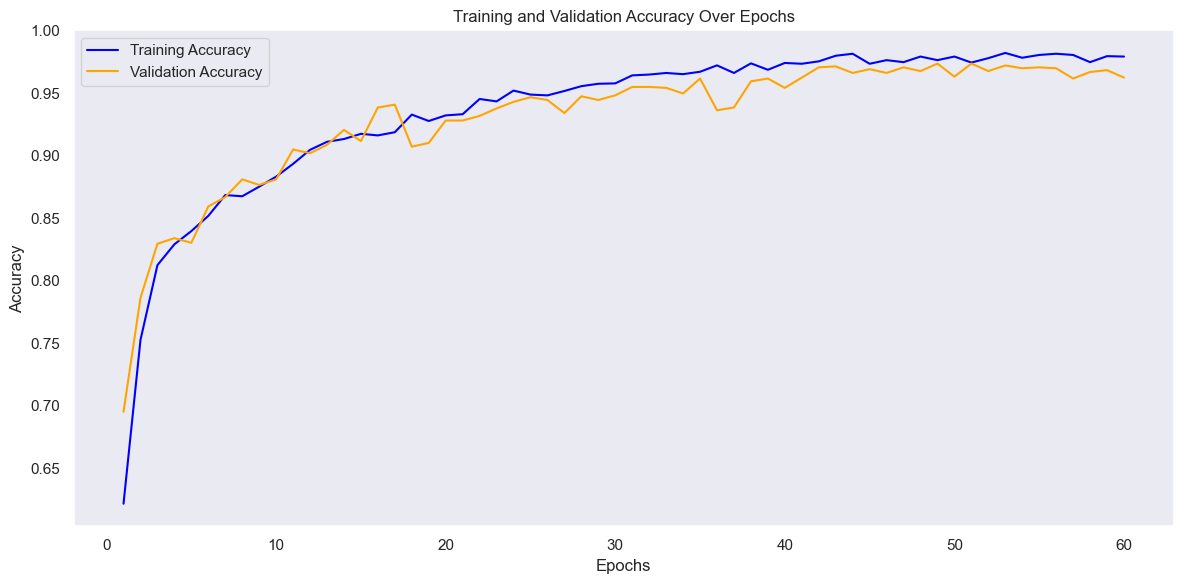

In [61]:
import matplotlib.pyplot as plt

# Extract the number of epochs from the training parameters
epochs = params_train["epochs"]

# Create a new figure for the accuracy plots
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.plot(range(1, epochs + 1), metric_hist["train"], label='Training Accuracy', color='blue')

# Plot validation accuracy
plt.plot(range(1, epochs + 1), metric_hist["val"], label='Validation Accuracy', color='orange')

# Add titles and labels
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to distinguish between training and validation accuracy
plt.legend()

# Optionally add gridlines for better readability
plt.grid()

# Show the plot
plt.tight_layout()  # Adjust layout to make it look nice
plt.show()


#### <b><span style='color:#e61227'>|</span> Save Model</b>

In [62]:
torch.save(cnn_model.state_dict(), 'model_cnn.pth')